<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/notebooks/poseEstimation/tests/mediapipe_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose estimation based on mediapipe

[mediapipe](https://mediapipe.dev/)

In [6]:
!pip install mediapipe
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
import mediapipe as mp

In [11]:
# we'll link the dataset from next-cloud
!apt install -y davfs2  > /dev/null

nextcloud = "/content/nextcloud"
Nextcloud_URL = "https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/" #@param {type:"string"}

os.makedirs(nextcloud, exist_ok=True)


if os.path.isfile("/etc/fstab"):
  os.remove("/etc/fstab")
with open("/etc/fstab" , "a") as f:
  f.write(Nextcloud_URL + " " + nextcloud + " davfs user,rw,auto 0 0")
!mount {nextcloud}

# open existing text file
txt = "/etc/fstab"
viewTxt = open(txt, "r")
txtContent = viewTxt.read()
print("txtContent: {}".format(txtContent))



Please enter the username to authenticate with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Username: colab
Please enter the password to authenticate user colab with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Password:  
/sbin/mount.davfs: warning: the server does not support locks
txtContent: https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ /content/nextcloud davfs user,rw,auto 0 0


## Define input/output folders

In [12]:
# clean and rebuild the image folders
input_folder = '/content/nextcloud/bgRemovalInference'

output_folder = '/content/output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

In [39]:
from google.colab.patches import cv2_imshow
from pathlib import Path
#grab a random sample from training set
def pick_random_sample(dir)-> (str, image):
  image_name = random.choice(os.listdir(input_folder))
  img_path = Path(input_folder) / image_name
  input_image = cv2.imread(str(img_path),1) 
  return image_name, input_image
img_name, img = pick_random_sample(input_folder)
# cv2_imshow(img)
# print('Image Dimensions :', img.shape)

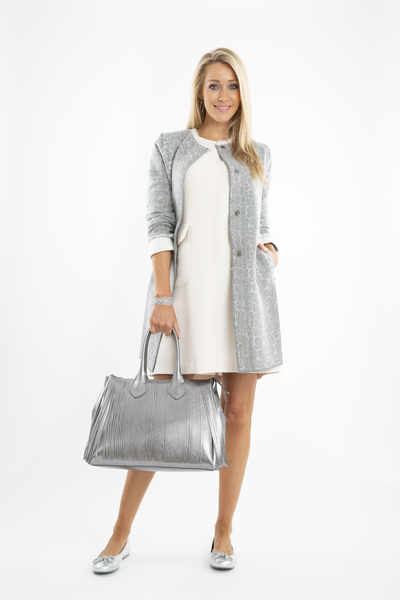

part01-AI-000006.jpg


In [41]:
cv2_imshow(img)
print(img_name)

In [14]:
# load all testing samples
images = {name: cv2.imread(str(Path(input_folder) / name),1) for name in os.listdir(input_folder)}

## mediapipe

In [28]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles
# help(mp_pose.Pose)

In [43]:
# Run MediaPipe Pose and draw pose landmarks.
def pose_landmarks(img_dict, save=True) -> list:
  with mp_pose.Pose(
      static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
    result_list = list()
    for name, image in img_dict.items():
      # Convert the BGR image to RGB and process it with MediaPipe Pose.
      results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      
      # Print nose landmark.
      image_hight, image_width, _ = image.shape
      if not results.pose_landmarks:
        continue
      # print(
      #   f'Nose coordinates: ('
      #   f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
      #   f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_hight})'
      # )

      # Draw pose landmarks.
      # print(f'Pose landmarks of {name}:')
      annotated_image = image.copy()
      mp_drawing.draw_landmarks(
          annotated_image,
          results.pose_landmarks,
          mp_pose.POSE_CONNECTIONS,
          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
      # resize_and_show(annotated_image)
      # cv2_imshow(annotated_image)
      result_list.append(annotated_image)
      if(save):
        cv2.imwrite("{}/pose_landmarks_{}.png".format(output_folder,name),annotated_image)
    return result_list
image_list = pose_landmarks({img_name: img}, save=True)

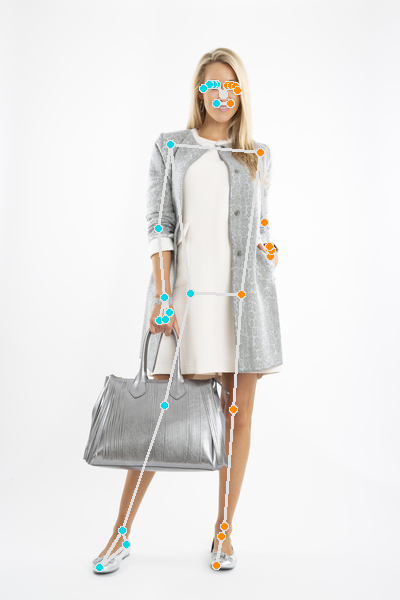

In [44]:
cv2_imshow(image_list[0])

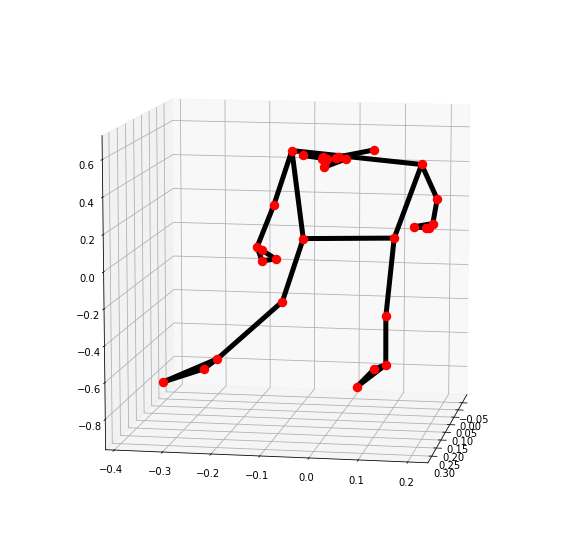

In [45]:
# Run MediaPipe Pose and plot 3d pose world landmarks.
def plot_3d_landmarks(img_dict, save=True) -> None:
  with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
    result_list=list()
    for name, image in img_dict.items():
      results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
      # we don't get an image back from this???
      # if(save):
      #   cv2.imwrite("{}/segm_{}.png".format(output_folder,name),annotated_image)
plot_3d_landmarks({img_name: img})

Pose segmentation of part01-AI-000006.jpg:


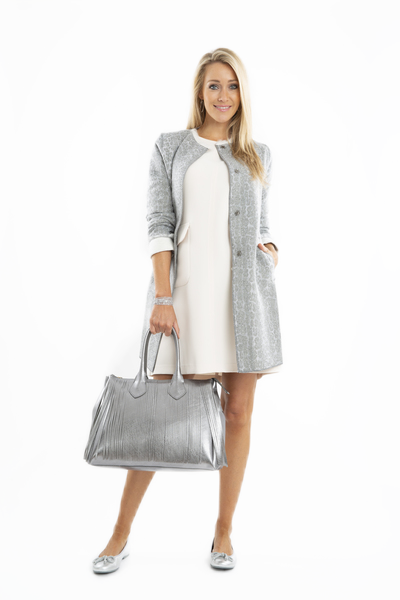

In [47]:
# Run MediaPipe Pose with `enable_segmentation=True` to get pose segmentation.
def mp_segment(image_dict, save = True) -> list:
  image_list = list()
  with mp_pose.Pose(
      static_image_mode=True, min_detection_confidence=0.5, 
      model_complexity=2, enable_segmentation=True) as pose:
    for name, image in image_dict.items():
      results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      # Draw pose segmentation.
      print(f'Pose segmentation of {name}:')
      annotated_image = image.copy()
      red_img = np.zeros_like(annotated_image, dtype=np.uint8)
      red_img[:, :] = (255,255,255)
      segm_2class = 0.2 + 0.8 * results.segmentation_mask
      segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2)
      annotated_image = annotated_image * segm_2class + red_img * (1 - segm_2class)
      # resize_and_show(annotated_image)
      image_list.append(annotated_image)
      if(save):
        cv2.imwrite("{}/segm_{}.png".format(output_folder,name),annotated_image)
    return image_list
segm_image = mp_segment({img_name: img}, save=True)    
cv2_imshow(segm_image[0])

In [22]:
# placeholder function to check if we want/need to combine the different images, not definitive yet.
def combine(img):
  with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, 
    model_complexity=2, enable_segmentation=True) as pose:
    for name, image in img.items():
      results = pose.process(cv2.cvtColor(image, cv2.COLOR_BAYER_BG2BGR))
    
    # # Draw pose segmentation.
    # fig, ax = plt.subplots(1,3)

    # print(f'Pose segmentation of {name}:')
    # segm_image = image.copy()
    # red_img = np.zeros_like(segm_image, dtype=np.uint8)
    # red_img[:, :] = (255,255,255)
    # segm_2class = 0.2 + 0.8 * results.segmentation_mask
    # segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2)
    # segm_image = segm_image * segm_2class + red_img * (1 - segm_2class)

    # bone_struct = mp_drawing.plot_landmarks(
    #     results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    # pose_img = image.copy()
    # mp_drawing.draw_landmarks(
    #     pose_img,
    #     results.pose_landmarks,
    #     mp_pose.POSE_CONNECTIONS,
    #     landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # ax[0,0].cv2_imshow(segm_image)

In [ ]:
rand_img = pick_random_sample(input_folder)
# cv2_imshow(rand_img)
# combine({'test':rand_img})
img = {'test':rand_img}
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, 
    model_complexity=2, enable_segmentation=True) as pose:
    for name, image in img.items():
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BAYER_BG2BGR))